In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer

from mip import Model, xsum, BINARY, maximize, minimize, CutType

from src.ADMM_MIP import ADMMxClassical_Optimizer

import warnings
warnings.simplefilter('ignore')

In [2]:
num_J = 3
num_M = 3

d_order = np.array([
    [2, 1, 2],
    [0, 2, 1],
    [1, 0, 0]
    ]).astype(int)

d_time = np.array([
    [2, 1, 1],
    [1, 2, 2],
    [2, 2, 1]
    ])

In [3]:
mdl_0 = QuadraticProgram('JSP')

# binary variables
for i,j,k in product(range(num_M), range(num_J), range(num_J)):
    if j>=k: continue
    mdl_0.binary_var(name=f'x({i},{j},{k})')

# maximum makespan
C_max = sum(d_time[i,j] for i,j in product(range(num_M), range(num_J)))

# continuous variables
mdl_0.continuous_var(lowerbound=0, name='C')
for i,j in product(range(num_M), range(num_J)):
    mdl_0.continuous_var(lowerbound=0, name=f'y({i},{j})')

# objective function
mdl_0.minimize(linear = {'C':1})

# ge constraints 1
for i,j in product(range(1, num_M), range(num_J)):
    mdl_0.linear_constraint(
        linear = {f'y({d_order[i-1,j]},{j})':-1, f'y({d_order[i,j]},{j})':1}, 
        sense = '>=', 
        rhs = d_time[d_order[i-1,j], j]
        )
    
# ge constraints 2
for i,j,k in product(range(num_M), range(num_J), range(num_J)):
    if j>=k: continue
    mdl_0.linear_constraint(
        linear = {f'y({i},{j})':1, f'y({i},{k})':-1, f'x({i},{j},{k})':C_max}, 
        sense = '>=', 
        rhs = d_time[i,k]
        )
    mdl_0.linear_constraint(
        linear = {f'y({i},{j})':-1, f'y({i},{k})':1, f'x({i},{j},{k})':-C_max}, 
        sense = '>=', 
        rhs = -C_max + d_time[i,j]
        )

# ge constraints 3
for j in range(num_J):
    mdl_0.linear_constraint(
        linear = {'C':1, f'y({d_order[-1,j]},{j})':-1}, 
        sense = '>=', 
        rhs = d_time[d_order[-1,j], j]
        )

print(mdl_0.prettyprint())

Problem name: JSP

Minimize
  C

Subject to
  Linear constraints (27)
    y(0,0) - y(2,0) >= 2  'c0'
    -y(1,1) + y(2,1) >= 2  'c1'
    y(1,2) - y(2,2) >= 1  'c2'
    -y(0,0) + y(1,0) >= 2  'c3'
    y(0,1) - y(2,1) >= 2  'c4'
    y(0,2) - y(1,2) >= 2  'c5'
    14*x(0,0,1) + y(0,0) - y(0,1) >= 1  'c6'
    -14*x(0,0,1) - y(0,0) + y(0,1) >= -12  'c7'
    14*x(0,0,2) + y(0,0) - y(0,2) >= 1  'c8'
    -14*x(0,0,2) - y(0,0) + y(0,2) >= -12  'c9'
    14*x(0,1,2) + y(0,1) - y(0,2) >= 1  'c10'
    -14*x(0,1,2) - y(0,1) + y(0,2) >= -13  'c11'
    14*x(1,0,1) + y(1,0) - y(1,1) >= 2  'c12'
    -14*x(1,0,1) - y(1,0) + y(1,1) >= -13  'c13'
    14*x(1,0,2) + y(1,0) - y(1,2) >= 2  'c14'
    -14*x(1,0,2) - y(1,0) + y(1,2) >= -13  'c15'
    14*x(1,1,2) + y(1,1) - y(1,2) >= 2  'c16'
    -14*x(1,1,2) - y(1,1) + y(1,2) >= -12  'c17'
    14*x(2,0,1) + y(2,0) - y(2,1) >= 2  'c18'
    -14*x(2,0,1) - y(2,0) + y(2,1) >= -12  'c19'
    14*x(2,0,2) + y(2,0) - y(2,2) >= 1  'c20'
    -14*x(2,0,2) - y(2,0) + y(2,2) 

In [4]:
model = Model()

n_vars = mdl_0.get_num_vars()

x = []
for idx in range(n_vars):
    if idx < mdl_0.get_num_binary_vars():
        x.append(model.add_var(var_type=BINARY))
    else:
        x.append(model.add_var())

c_obj = mdl_0.objective.linear.to_array()
if mdl_0.objective.sense.name == 'MINIMIZE':
    model.objective = minimize(xsum(c_obj[j]*x[j] for j in range(n_vars)))
else:
    model.objective = maximize(xsum(c_obj[j]*x[j] for j in range(n_vars)))

for idx in range(mdl_0.get_num_linear_constraints()):
    l_const_info = mdl_0.get_linear_constraint(idx)
    a = l_const_info.linear.to_array()
    b = l_const_info.rhs
    sense = l_const_info.sense.label
    if sense == '<=':
        model += xsum(a[j]*x[j] for j in range(n_vars)) <= b
    elif sense == '>=':
        model += xsum(a[j]*x[j] for j in range(n_vars)) >= b
    else:
        model += xsum(a[j]*x[j] for j in range(n_vars)) == b

model.optimize(relax=True)
cp = model.generate_cuts(cut_types=[
    CutType.GOMORY, 
    #CutType.KNAPSACK_COVER,
    #CutType.CLIQUE, 
    ])

n_cuts = len(cp.cuts)

a_cut = np.zeros((n_cuts, n_vars))
b_cut = np.zeros(n_cuts)
for k in range(n_cuts):
    print(f'{k} sense: {cp.cuts[k].sense}')
    b_cut[k] = -cp.cuts[k].const

    for idx in range(n_vars):
        d = cp.cuts[k].expr.get(x[idx])
        if d==None: continue
        a_cut[k,idx] = d


Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Dual Simplex

Clp0024I Matrix will be packed to eliminate 441 small elements
Coin0506I Presolve 27 (0) rows, 19 (0) columns and 72 (0) elements
Clp0014I Perturbing problem by 0.001% of 1.3908042 - largest nonzero change 9.7001077e-05 ( 0.0069744594%) - largest zero change 9.2907133e-05
Clp0000I Optimal - objective value 5
Clp0032I Optimal objective 5 - 12 iterations time 0.002
0 sense: <
1 sense: <
2 sense: <
3 sense: <
4 sense: <


In [5]:
mdl = QuadraticProgram('target problem')

for idx in range(mdl_0.get_num_vars()):
    if idx < mdl_0.get_num_binary_vars():
        mdl.binary_var(name=mdl_0.get_variable(idx).name)
    else:
        mdl.continuous_var(name=mdl_0.get_variable(idx).name)

c_obj = mdl_0.objective.linear.to_array()
if mdl_0.objective.sense.name == 'MINIMIZE':
    mdl.minimize(linear=c_obj)
else:
    mdl.maximize(linear=c_obj)

for idx in range(mdl_0.get_num_linear_constraints()):
    l_const_info = mdl_0.get_linear_constraint(idx)
    a = l_const_info.linear.to_array()
    b = l_const_info.rhs
    sense = l_const_info.sense.label
    mdl.linear_constraint(linear=a, sense=sense, rhs=b)

#for idx in range(n_cuts):
#    mdl.linear_constraint(linear=a_cut[idx], sense='<=', rhs=b_cut[idx])

print(mdl.prettyprint())

Problem name: target problem

Minimize
  C

Subject to
  Linear constraints (27)
    y(0,0) - y(2,0) >= 2  'c0'
    -y(1,1) + y(2,1) >= 2  'c1'
    y(1,2) - y(2,2) >= 1  'c2'
    -y(0,0) + y(1,0) >= 2  'c3'
    y(0,1) - y(2,1) >= 2  'c4'
    y(0,2) - y(1,2) >= 2  'c5'
    14*x(0,0,1) + y(0,0) - y(0,1) >= 1  'c6'
    -14*x(0,0,1) - y(0,0) + y(0,1) >= -12  'c7'
    14*x(0,0,2) + y(0,0) - y(0,2) >= 1  'c8'
    -14*x(0,0,2) - y(0,0) + y(0,2) >= -12  'c9'
    14*x(0,1,2) + y(0,1) - y(0,2) >= 1  'c10'
    -14*x(0,1,2) - y(0,1) + y(0,2) >= -13  'c11'
    14*x(1,0,1) + y(1,0) - y(1,1) >= 2  'c12'
    -14*x(1,0,1) - y(1,0) + y(1,1) >= -13  'c13'
    14*x(1,0,2) + y(1,0) - y(1,2) >= 2  'c14'
    -14*x(1,0,2) - y(1,0) + y(1,2) >= -13  'c15'
    14*x(1,1,2) + y(1,1) - y(1,2) >= 2  'c16'
    -14*x(1,1,2) - y(1,1) + y(1,2) >= -12  'c17'
    14*x(2,0,1) + y(2,0) - y(2,1) >= 2  'c18'
    -14*x(2,0,1) - y(2,0) + y(2,1) >= -12  'c19'
    14*x(2,0,2) + y(2,0) - y(2,2) >= 1  'c20'
    -14*x(2,0,2) - y(2,0

In [6]:
cplex_result = CplexOptimizer().solve(mdl)
cplex_optval = cplex_result.fval
cplex_xsol = cplex_result.x

n_bin = mdl.get_num_binary_vars()

print(
        '-'*110,
        '[CPLEX Result]',
        f'   optimal value: {cplex_optval:.3f}',
        f'   optimal solution (binary): {cplex_xsol[:n_bin].astype(int)}',
        f'   optimal solution (continuous): {cplex_xsol[n_bin:]}',
        f'   status: {cplex_result.status.name}',
        '-'*110,
        sep='\n'
    )

--------------------------------------------------------------------------------------------------------------
[CPLEX Result]
   optimal value: 7.000
   optimal solution (binary): [1 1 0 0 0 1 1 1 0]
   optimal solution (continuous): [7. 3. 6. 5. 6. 0. 3. 0. 3. 2.]
   status: SUCCESS
--------------------------------------------------------------------------------------------------------------


In [7]:
ADMMxClassical = ADMMxClassical_Optimizer(mdl)

n_bin_vars = ADMMxClassical.n_bin_vars
n_cont_vars = ADMMxClassical.n_cont_vars
n_eq = ADMMxClassical.n_eq
n_le = ADMMxClassical.n_le
n_ge = ADMMxClassical.n_ge

print(
        '-'*50,
        '[Problem Info]',
        '- Decision Variables',
        f'    number of binary vars: \t {n_bin_vars}',
        f'    number of continuous vars: \t {n_cont_vars}',
        '- Linear Constraints',
        f'    number of eq constraints: \t {n_eq}',
        f'    number of le constraints: \t {n_le}',
        f'    number of ge constraints: \t {n_ge}',
        '-'*50,
        sep='\n'
    )

--------------------------------------------------
[Problem Info]
- Decision Variables
    number of binary vars: 	 9
    number of continuous vars: 	 10
- Linear Constraints
    number of eq constraints: 	 0
    number of le constraints: 	 0
    number of ge constraints: 	 27
--------------------------------------------------


In [8]:
rmdl = QuadraticProgram('relaxed problem')

for idx in range(mdl_0.get_num_vars()):
        rmdl.continuous_var(
              lowerbound=mdl_0.get_variable(idx).lowerbound, 
              upperbound=mdl_0.get_variable(idx).upperbound, 
              name=mdl_0.get_variable(idx).name
              )

c_obj = mdl_0.objective.linear.to_array()
if mdl_0.objective.sense.name == 'MINIMIZE':
    rmdl.minimize(linear=c_obj)
else:
    rmdl.maximize(linear=c_obj)

for idx in range(mdl_0.get_num_linear_constraints()):
    l_const_info = mdl_0.get_linear_constraint(idx)
    a = l_const_info.linear.to_array()
    b = l_const_info.rhs
    sense = l_const_info.sense.label
    rmdl.linear_constraint(linear=a, sense=sense, rhs=b)

for idx in range(n_cuts):
    rmdl.linear_constraint(linear=a_cut[idx], sense='<=', rhs=b_cut[idx])

relax_result = CplexOptimizer().solve(rmdl)
relax_obj = relax_result.fval
relax_sol = relax_result.x

np.set_printoptions(formatter={'float': '{:.3f}'.format})
print(
        '-'*110,
        '[Relaxation]',
        f'   optimal value: {relax_obj:.3f}',
        f'   relaxed solution: {relax_sol}',
        f'   status: {relax_result.status.name}',
        '-'*110,
        sep='\n'
    )

--------------------------------------------------------------------------------------------------------------
[Relaxation]
   optimal value: 5.071
   relaxed solution: [0.976 1.000 0.077 0.000 0.000 1.000 0.995 0.929 0.005 5.071 2.071 4.000
 4.071 4.071 0.000 2.071 0.071 2.000 1.071]
   status: INFEASIBLE
--------------------------------------------------------------------------------------------------------------


In [9]:
# config
step_max = 5
n_lin_const = ADMMxClassical.n_lin_const
x_ini = relax_sol.copy()
lam_ini = np.full(n_lin_const, 1.)
rho = 10.

admm_result = ADMMxClassical.solve(step_max, x_ini, lam_ini, rho)
x_sol = admm_result.x
n_bin = mdl.get_num_binary_vars()

np.set_printoptions(formatter={'float': '{:.3f}'.format})
pd.options.display.float_format = '{:.3f}'.format
print(
        '-'*110,
        '[ADMMxClassic Result]',
        f'   optimal value: {admm_result.fval:.3f}',
        f'   optimal solution (binary): {x_sol[:n_bin].astype(int)}',
        f'   optimal solution (continuous): {x_sol[n_bin:]}',
        f'   status: {admm_result.status.name}',
        '-'*110,
        ADMMxClassical.opt_record,
        '-'*110,
        sep='\n'
    )

--------------------------------------------------------------------------------------------------------------
[ADMMxClassic Result]
   optimal value: 7.000
   optimal solution (binary): [1 1 1 0 0 1 1 1 0]
   optimal solution (continuous): [7.000 2.156 5.000 6.000 5.814 0.043 3.409 0.000 3.000 2.000]
   status: SUCCESS
--------------------------------------------------------------------------------------------------------------
        objective function value      status
step 0                     5.071  infeasible
step 1                     7.000    feasible
step 2                     7.000  infeasible
step 3                     7.000    feasible
step 4                     7.000    feasible
step 5                     7.000    feasible
--------------------------------------------------------------------------------------------------------------


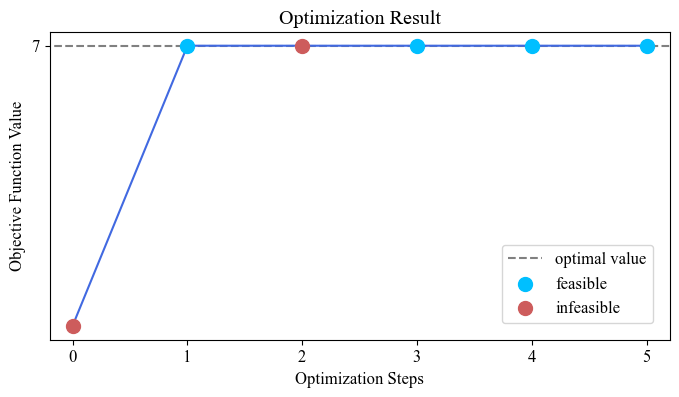

In [10]:
plt.style.use('default')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

plt.rcParams["mathtext.fontset"] = 'cm'
plt.rcParams['mathtext.default'] = 'it'

plt.figure(figsize=(8, 4))

exact_val = cplex_optval
plt.hlines(exact_val, -1, len(ADMMxClassical.opt_record.index), colors='gray', zorder=1, linestyle='dashed', label='optimal value')

if mdl_0.objective.sense.name == 'MINIMIZE':
    Y_data = ADMMxClassical.opt_record.loc[:,'objective function value'].to_numpy()
else:
    Y_data = -ADMMxClassical.opt_record.loc[:,'objective function value'].to_numpy()
X_data = np.arange(len(Y_data))
plt.plot(X_data, Y_data, color='royalblue', zorder=2)

X_0, Y_0 = [], []
X_1, Y_1 = [], []
for k in range(len(Y_data)):
    if ADMMxClassical.opt_record.loc[f'step {k}', 'status'] == 'feasible':
        X_1 = np.append(X_1, X_data[k])
        Y_1 = np.append(Y_1, Y_data[k])
    else:
        X_0 = np.append(X_0, X_data[k])
        Y_0 = np.append(Y_0, Y_data[k])

plt.scatter(X_1, Y_1, c='deepskyblue', s=100, zorder=3, label=('feasible'))
plt.scatter(X_0, Y_0, c='indianred', s=100, zorder=3, label='infeasible')

plt.xlim(-0.2, len(Y_data)-0.8)

plt.xticks(np.array([k for k in range(0, len(Y_data), 1)]))
plt.yticks([exact_val])

plt.title(f'Optimization Result')
plt.xlabel('Optimization Steps')
plt.ylabel('Objective Function Value')

plt.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=1, fontsize='medium')

plt.show()

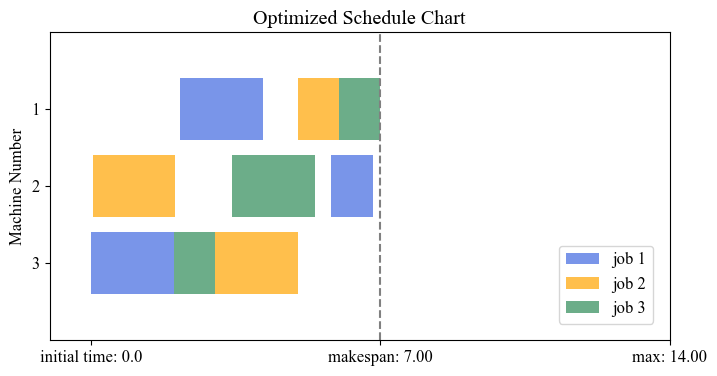

In [11]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams["figure.figsize"] = [8, 4]

# Declaring a figure "gnt"
fig, gnt = plt.subplots()
 
# Setting Y-axis limits
gnt.set_ylim(0, num_M+1)
 
# Setting X-axis limits
gnt.set_xlim(-1, C_max)
 
# Setting labels for x-axis and y-axis
#gnt.set_xlabel('Time')
gnt.set_ylabel('Machine Number')
 
# Setting ticks on y-axis
gnt.set_yticks([k for k in range(1,num_M+1)])
# Labelling tickes of y-axis
gnt.set_yticklabels(['3', '2', '1'])

c_val = admm_result.variables_dict['C']
gnt.set_xticks(
    [0, c_val, C_max],
    [f'initial time: {0.}', f'makespan: {c_val:.2f}', f'max: {C_max:.2f}']
    )

ofs = 0.4
f_color_list = ['royalblue', 'orange', 'seagreen']
label_list = [
    ['job 1', 'job 2', 'job 3'],
    ['', '', ''],
    ['', '', ''],
]
x_dict = admm_result.variables_dict
for i,j in product(range(num_M), range(num_J)):
    gnt.broken_barh(
        [(x_dict[f'y({i},{j})'], d_time[i,j])], (num_M-i-ofs, 2*ofs), 
        facecolors =(f_color_list[j]), alpha = 0.7,
        label = label_list[i][j]
        )

gnt.vlines(x=c_val, ymin=0, ymax=num_M+1, linestyle='dashed', color='gray', linewidth=1.5)

plt.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=1, fontsize='medium')
plt.title('Optimized Schedule Chart')

plt.show()

In [12]:
admm_params = ADMMParameters(
    rho_initial=10, beta=10, factor_c=10, maxiter=100, three_block=True, tol=1.0e-6
)

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(
    params=admm_params, qubo_optimizer=CplexOptimizer(), continuous_optimizer=CplexOptimizer()
)

# run ADMM to solve problem
admm3b_result = admm.solve(mdl)
print(admm3b_result.prettyprint())

data = admm3b_result.state.residuals

print('-'*80)
for step in range(len(data)):
    print(f'step = {step} \t err = {data[step]}')

objective function value: 5.00000000088488
variable values: x(0,0,1)=0.0, x(0,0,2)=0.0, x(0,1,2)=0.0, x(1,0,1)=0.0, x(1,0,2)=0.0, x(1,1,2)=0.0, x(2,0,1)=0.0, x(2,0,2)=0.0, x(2,1,2)=0.0, C=5.00000000088488, y(0,0)=2.0000000006019603, y(0,1)=4.000000000453397, y(0,2)=3.000000000990883, y(1,0)=4.000000000709479, y(1,1)=1.337083054186923e-10, y(1,2)=1.0000000004933423, y(2,0)=4.2537947447053355e-10, y(2,1)=2.0000000002363847, y(2,2)=2.2361021929822262e-10
status: INFEASIBLE
--------------------------------------------------------------------------------
step = 0 	 err = 0.2230356445365464
step = 1 	 err = 0.1062074497388011
step = 2 	 err = 0.04805766951595137
step = 3 	 err = 0.020616760788335194
step = 4 	 err = 0.008366852282303845
step = 5 	 err = 0.003205064270257699
step = 6 	 err = 0.0011564112935747394
step = 7 	 err = 0.00039217452416273477
step = 8 	 err = 0.00012475411596318264
step = 9 	 err = 3.71528599665685e-05
step = 10 	 err = 1.0341307548351733e-05
step = 11 	 err = 2.694